In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv', index_col='Unnamed: 0')

In [4]:
from ModelTesters.BaselineModelTester import BaselineModelTester
from AutoValidator.ErrorMetrics import calculate_all_errors

## Random Walk on each dataset

In [5]:
class RandomWalk():
    
    def __init__(self, horizon):
        self.horizon = horizon
    
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        comb_data = np.hstack([self.train, data])
        
        results = np.zeros((len(data), self.horizon))
        
        std = np.std(comb_data)
        
        results[:, 0] = data[:]
        
        noise = np.random.normal(0, std, (len(data), self.horizon))
        results += noise        
        
        return results.cumsum(axis=1)
    
    def __repr__(self):
        return 'Random Walk'

In [6]:
walk = RandomWalk(5)

In [7]:
d = np.arange(0, 100)

In [8]:
walk.fit(d[:80], d[:80])

In [9]:
a = walk.predict(d[80:])

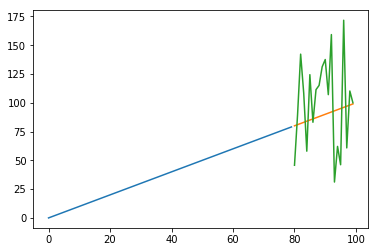

In [10]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

## Mean estimation

In [11]:
class MeanEstimator():
    
    def __init__(self, horizon):
        self.horizon = horizon
        
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        return np.repeat( pd.Series(np.hstack([self.train, data])).expanding().mean()[len(self.train):], self.horizon).values.reshape(len(data), self.horizon)    

    def __repr__(self):
        return 'Mean Estimator'

In [12]:
me = MeanEstimator(5)

In [13]:
d = np.arange(0, 100)

In [14]:
me.fit(d[:80], d[:80])

In [15]:
a = me.predict(d[80:])

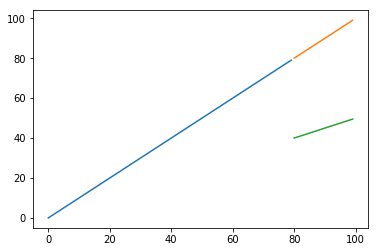

In [16]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

## Moving Average Estimator

In [17]:
class MovingAvgEstimator():
    
    def __init__(self, horizon, back_horizon=None):
        self.horizon = horizon
        
        if back_horizon is None:
            back_horizon = horizon
        self.back_horizon = back_horizon
        
    def fit(self, train, labels):
        self.starting_horizon = labels[-(self.back_horizon - 1):]
        
    def predict(self, data):
        comb_data = np.hstack([self.starting_horizon, data])
        
        return np.repeat(pd.Series(comb_data).rolling(self.back_horizon).mean().dropna(axis=0).values, self.horizon).reshape(len(data), self.horizon)
    
    def __repr__(self):
        return 'Moving Avg Estimator: (h={:d})'.format(self.horizon)

In [18]:
mva = MovingAvgEstimator(5, 60)

In [19]:
d = np.arange(0, 100)

In [20]:
d[80:]

array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
       97, 98, 99])

In [21]:
mva.fit(d[:80], d[:80])

In [22]:
a = mva.predict(d[80:])

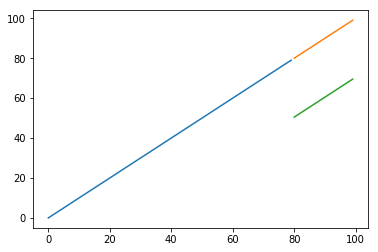

In [23]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

In [31]:
def speed_up_calc(tester, data, horizon):
    # Loading bar
    tester.progressBar.set_length(len(data.columns))

    # walk speed up
    for i, column in enumerate(data.columns):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        tester.model.fit(train, train)
        pred = tester.model.predict(test)
        tester.predictions[column] = pred

        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)

        tester.progressBar.progress()

## 1 minute horizon

In [42]:
horizon = 1

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 15)

In [43]:
one_min_walk_tester = BaselineModelTester(data, walk, horizon, 0.20)
speed_up_calc(one_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [44]:
one_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,297.871793,373.598194,669.597122,105.898551,1.252480,934.71846,1.010880
window_1_1,303.329801,379.683538,1582.277406,106.418440,1.506089,349.04745,1.015766
window_1_2,342.634391,429.734314,776.179631,108.219401,1.106658,-238.64318,1.053296
window_1_3,380.764274,478.065244,489.613564,101.967802,0.974837,174.33102,0.989148
window_1_4,332.860574,417.063464,2248.512479,116.754229,1.111557,467.88622,1.153274


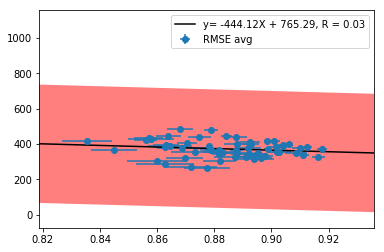

In [45]:
one_min_walk_tester.compare_hurst(hurst_estimates)

In [130]:
one_min_walk_tester.errors.to_csv('results/one_minute_random_walk_results.csv')

In [46]:
one_min_mean_tester = BaselineModelTester(data, mean, horizon, 0.20)
speed_up_calc(one_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [47]:
one_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,294.708267,383.840209,100.394376,198.038759,1.239178,924.79135,1.000144
window_1_1,298.553692,396.919130,102.295595,198.005408,1.482374,343.55149,0.999772
window_1_2,325.316326,427.998295,100.834025,197.182665,1.050724,-226.58124,1.000058
window_1_3,384.556657,474.143761,100.827081,196.979884,0.984546,176.06735,0.999000
window_1_4,288.599218,414.853780,106.940037,195.603028,0.963750,405.67015,0.999920


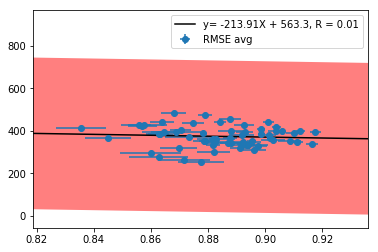

In [49]:
one_min_mean_tester_tester.compare_hurst(hurst_estimates)

In [131]:
one_min_mean_tester.errors.to_csv('results/one_minute_mean_results.csv')

In [51]:
one_min_mva_tester = BaselineModelTester(data, mva, horizon, 0.20)
speed_up_calc(one_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


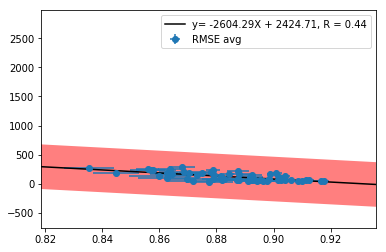

In [54]:
one_min_mva_tester.compare_hurst(hurst_estimates)

In [55]:
one_min_mva_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE,RMSE avg,RMSE std
window_1_0,61.903223,163.040360,70.210783,25.191812,0.260288,194.25164,0.210079,163.040360,NaN
window_1_1,69.075982,203.610038,62.901886,23.208126,0.342975,79.48707,0.231316,203.610038,NaN
window_1_2,95.190428,231.326460,130.176008,31.404616,0.307451,-66.29967,0.292626,231.326460,NaN
window_1_3,101.327250,243.014126,94.969074,30.051650,0.259419,46.39218,0.263228,243.014126,NaN
window_1_4,112.721159,269.806095,229.511888,35.737864,0.376422,158.44675,0.390549,269.806095,NaN


In [133]:
one_min_mva_tester.errors.to_csv('results/one_minute_mva_results.csv')

## 5 Minute horizon

In [95]:
horizon = 5

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [116]:
five_min_walk_tester = ModelTester(data, walk, horizon, 0.20)
speed_up_calc(five_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [121]:
five_min_walk_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,505.555459,1048.396935,2.125741,1586.42755,1.715613,657.337236,NaN,125.173514
window_1_1,519.197821,2593.260452,2.577913,597.45095,1.738591,677.092128,NaN,125.981802
window_1_2,591.131144,1463.623036,1.909266,-411.71996,1.817177,771.002375,NaN,127.983273
window_1_3,659.347957,883.828414,1.688070,301.87918,1.712945,857.393653,NaN,123.234682
window_1_4,579.631898,4871.169645,1.935627,814.76090,2.008431,756.295498,NaN,135.266085


In [136]:
five_min_walk_tester.errors.to_csv('results/five_minute_random_walk_results.csv')

In [117]:
five_min_mean_tester = ModelTester(data, mean, horizon, 0.20)
speed_up_calc(five_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [118]:
five_min_mean_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,294.735580,100.398976,1.239293,924.87705,1.000191,383.871506,NaN,198.047930
window_1_1,298.577213,102.300430,1.482491,343.57856,0.999819,396.950630,NaN,198.014429
window_1_2,325.335164,100.837619,1.050784,-226.59436,1.000102,428.026491,NaN,197.191832
window_1_3,384.552813,100.831235,0.984537,176.06559,0.999044,474.147254,NaN,196.989060
window_1_4,288.589003,106.944517,0.963716,405.65579,0.999964,414.849820,NaN,195.611052


In [137]:
five_min_mean_tester.errors.to_csv('results/five_minute_mean_results.csv')

In [119]:
five_min_mva_tester = ModelTester(data, mva, horizon, 0.20)
speed_up_calc(five_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


In [120]:
five_min_mva_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,92.004262,115.133188,0.386856,288.70838,0.312218,208.059042,NaN,37.537537
window_1_1,99.286771,94.859098,0.492977,114.25120,0.332473,251.944313,NaN,34.478342
window_1_2,130.370188,161.372089,0.421076,-90.80220,0.400767,286.018674,NaN,43.063600
window_1_3,139.142118,118.738351,0.356233,63.70552,0.361483,298.247507,NaN,41.153721
window_1_4,151.932361,342.077881,0.507364,213.56407,0.526447,327.763359,NaN,49.662307


In [138]:
five_min_mva_tester.errors.to_csv('results/five_minute_mva_results.csv')

## 60 minute horizon

In [123]:
horizon = 60

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 45)

In [124]:
sixty_min_walk_tester = ModelTester(data, walk, horizon, 0.20)
speed_up_calc(sixty_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [125]:
sixty_min_walk_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,1566.714080,3541.700606,6.587660,4916.33180,5.314813,2074.016188,NaN,157.948718
window_1_1,1610.817819,6175.005098,7.998009,1853.59915,5.392209,2132.804913,NaN,158.915329
window_1_2,1826.280423,4326.363810,5.898616,-1271.99542,5.612691,2413.516675,NaN,160.207233
window_1_3,2029.166842,2800.396814,5.195097,929.04392,5.274907,2684.844343,NaN,157.195112
window_1_4,1778.263410,13389.900518,5.938347,2499.62001,6.163386,2355.066259,NaN,164.386854


In [139]:
sixty_min_walk_tester.errors.to_csv('results/sixty_minute_random_walk_results.csv')

In [126]:
sixty_min_mean_tester = ModelTester(data, mean, horizon, 0.20)
speed_up_calc(sixty_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [129]:
sixty_min_mean_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,295.001364,100.450509,1.240411,925.71108,1.000742,384.186327,NaN,198.177185
window_1_1,298.831773,102.366094,1.483755,343.87149,1.000339,397.267062,NaN,198.137860
window_1_2,325.561436,100.896857,1.051515,-226.75195,1.000545,428.307949,NaN,197.306237
window_1_3,384.494467,100.883576,0.984387,176.03887,0.999510,474.092346,NaN,197.099311
window_1_4,288.611209,107.109562,0.963791,405.68700,1.000314,414.884364,NaN,195.693513


In [140]:
sixty_min_mean_tester.errors.to_csv('results/sixty_minute_mean_results.csv')

In [127]:
sixty_min_mva_tester = ModelTester(data, mva, horizon, 0.20)
speed_up_calc(sixty_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


In [128]:
five_min_mva_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,92.004262,115.133188,0.386856,288.70838,0.312218,208.059042,NaN,37.537537
window_1_1,99.286771,94.859098,0.492977,114.25120,0.332473,251.944313,NaN,34.478342
window_1_2,130.370188,161.372089,0.421076,-90.80220,0.400767,286.018674,NaN,43.063600
window_1_3,139.142118,118.738351,0.356233,63.70552,0.361483,298.247507,NaN,41.153721
window_1_4,151.932361,342.077881,0.507364,213.56407,0.526447,327.763359,NaN,49.662307


In [141]:
sixty_min_mva_tester.errors.to_csv('results/sixty_minute_mva_results.csv')

In [83]:
horizon = 5
one_min_walk_tester = ModelTester(data, walk, horizon, 0.20)
speed_up_calc(one_min_walk_tester, data, horizon)

one_min_walk_tester.errors.head()

one_min_mean_tester = ModelTester(data, mean, horizon, 0.20)
speed_up_calc(one_min_mean_tester, data, horizon)

one_min_mean_tester.errors.head()

one_min_mva_tester = ModelTester(data, mva, horizon, 0.20)
speed_up_calc(one_min_mva_tester, data, horizon)

one_min_mva_tester.errors.head()
walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [84]:
five_min_walk_tester = ModelTester(data, walk, horizon, 0.20)

In [76]:
# Loading bar
one_min_walk_tester.progressBar.set_length(len(data.columns))

# walk speed up
for i, column in enumerate(data.columns):
    # Split into train and test data
    split = int(0.20 * len(data))
    train, test = data[column][:split].values, data[column][split:].values
    # Round to be a multiple of the horizon
    test = test[:len(test) - len(test) % horizon]
    
    one_min_walk_tester.model.fit(train, train)
    pred = one_min_walk_tester.model.predict(test)
    one_min_walk_tester.predictions[column] = pred
    
    errors = {}
    for key, value in calculate_all_errors(train, test, pred, horizon).items():
        errors[key] = [value]
    
    t = pd.DataFrame.from_dict(errors)
    t.set_index(keys=[[column]], inplace=True)
    one_min_walk_tester.errors = one_min_walk_tester.errors.append(t)
    
    one_min_walk_tester.progressBar.progress()

Progress: [####################] 100.0%


In [78]:
one_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE,RW_ASE
window_1_0,296.632363,371.738702,651.538015,105.270596,1.247269,930.82914,1.006685,0.741982
window_1_1,303.992844,380.932488,1760.638916,106.746890,1.509381,349.81043,1.017990,0.747234
window_1_2,344.230883,431.003083,818.202024,108.429280,1.111815,-239.75513,1.058202,0.746585
window_1_3,383.129354,480.089837,542.777229,102.342638,0.980892,175.41386,0.995280,0.743181
window_1_4,334.262809,419.057095,1966.866634,116.520042,1.116240,469.85728,1.158104,0.743676


In [66]:
# results = one_min_tester.test_models()

# Loading bar
one_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
one_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    train, test = train.values, test.values
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    one_min_tester.results[repr(walk)][column] = pred
    
    errors = calculate_all_errors()
    one_min_tester.errors
    
    one_min_tester.progressBar.progress()

# Mean speed up
one_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    one_min_tester.results[repr(mean)][column] = pred
    one_min_tester.progressBar.progress()
    
# MVA speed up
one_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    one_min_tester.results[repr(mva)][column] = pred
    one_min_tester.progressBar.progress()
    
    
one_min_tester.add_model(walk)
one_min_tester.add_model(mean)
one_min_tester.add_model(mva)

Progress: [####################] 100.0%


In [259]:
one_min_errors = one_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [260]:
one_min_errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=1)_RMSE,Moving Avg Estimator: (h=1)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,370.533968,1.004252,383.837483,1.000144,163.039179,0.210079,305.803544,123.816371,0.738158,0.457335
window_1_1,379.806208,1.014568,396.917204,0.999950,203.608563,0.231355,326.777325,107.009834,0.748624,0.448028
window_1_2,430.624012,1.055514,427.997371,0.999772,231.324784,0.292538,363.315389,114.314761,0.782608,0.425328
window_1_3,482.762616,1.000951,474.148053,0.999513,243.012425,0.263358,399.974365,136.001252,0.754607,0.425435
window_1_4,418.734964,1.158180,414.860941,0.999991,269.804186,0.390564,367.800030,84.888993,0.849578,0.405310


In [261]:
one_min_errors.to_csv('results/one_minute_baseline_results.csv')

Progress: [####################] 100.0%


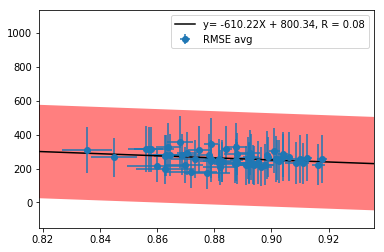

In [263]:
one_min_tester.compare_hurst(hurst_estimates)

## 5 minute horizon

In [244]:
horizon = 5

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [245]:
five_min_tester = ModelTester(data, horizon, 0.20)

# five_min_tester.add_model(walk)
# five_min_tester.add_model(mean)
# five_min_tester.add_model(mva)

In [247]:
# results = five_min_tester.test_models()

# Loading bar
five_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
five_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    five_min_tester.results[repr(walk)][column] = pred
    five_min_tester.progressBar.progress()

# Mean speed up
five_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    five_min_tester.results[repr(mean)][column] = pred
    five_min_tester.progressBar.progress()
    
# MVA speed up
five_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    five_min_tester.results[repr(mva)][column] = pred
    five_min_tester.progressBar.progress()
    
    
five_min_tester.add_model(walk)
five_min_tester.add_model(mean)
five_min_tester.add_model(mva)


Progress: [####################] 100.0%


In [248]:
errors = five_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [249]:
errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=5)_RMSE,Moving Avg Estimator: (h=5)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,661.263658,1.727968,383.861537,1.000191,208.020821,0.312315,417.715339,228.510016,1.013492,0.707920
window_1_1,679.470486,1.742633,396.939533,0.999996,251.951506,0.332516,442.787175,217.415787,1.025049,0.705392
window_1_2,775.806363,1.828303,428.017916,0.999817,286.065923,0.400614,496.630068,251.976477,1.076245,0.716906
window_1_3,857.250337,1.713267,474.160543,0.999559,298.229288,0.361694,543.213389,285.836238,1.024840,0.676141
window_1_4,757.849641,2.009544,414.865606,1.000035,327.760376,0.526636,500.158541,227.377126,1.178738,0.757433


In [250]:
errors.to_csv('results/baseline_five_minutes_results.cssv')

Progress: [####################] 100.0%


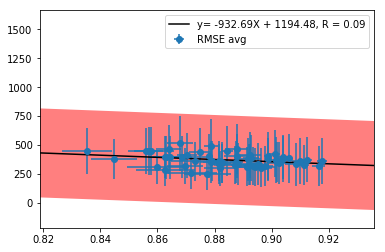

In [251]:
five_min_tester.compare_hurst(hurst_estimates)

## 60 minute horizon

In [273]:
horizon = 60

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 15)

In [274]:
sixty_min_tester = ModelTester(data, horizon, 0.20)

# sixty_min_tester.add_model(walk)
# sixty_min_tester.add_model(mean)
# sixty_min_tester.add_model(mva)

In [275]:
# results = sixty_min_tester.test_models()

# Loading bar
sixty_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
sixty_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    sixty_min_tester.results[repr(walk)][column] = pred
    sixty_min_tester.progressBar.progress()

# Mean speed up
sixty_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    sixty_min_tester.results[repr(mean)][column] = pred
    sixty_min_tester.progressBar.progress()
    
# MVA speed up
sixty_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    sixty_min_tester.results[repr(mva)][column] = pred
    sixty_min_tester.progressBar.progress()
    
    
sixty_min_tester.add_model(walk)
sixty_min_tester.add_model(mean)
sixty_min_tester.add_model(mva)

Progress: [####################] 100.0%


In [276]:
sixty_min_errors = sixty_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [277]:
sixty_min_errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=60)_RMSE,Moving Avg Estimator: (h=60)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,2065.975932,5.322430,384.073938,1.000736,278.989790,0.474663,909.679887,1002.759232,2.265943,2.660033
window_1_1,2147.844412,5.452250,397.132707,1.000513,328.530664,0.478586,957.835928,1031.148246,2.310450,2.733365
window_1_2,2357.930876,5.457775,428.186035,1.000261,375.524678,0.564759,1053.880530,1129.647637,2.340932,2.708034
window_1_3,2721.066358,5.349110,474.332294,1.000025,384.617480,0.502252,1193.338711,1323.811169,2.283796,2.666282
window_1_4,2320.248875,6.061397,414.946261,1.000384,408.395873,0.703408,1047.863670,1101.922779,2.588396,3.011370


In [270]:
sixty_min_errors.to_csv('results/sixty_minute_baseline_results.csv')

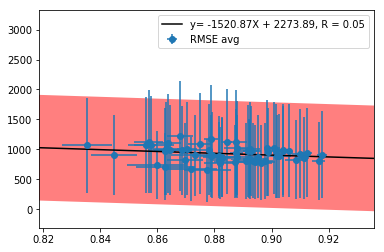

In [271]:
sixty_min_tester.compare_hurst(hurst_estimates, errors=sixty_min_errors)

<IPython.core.display.Javascript object>


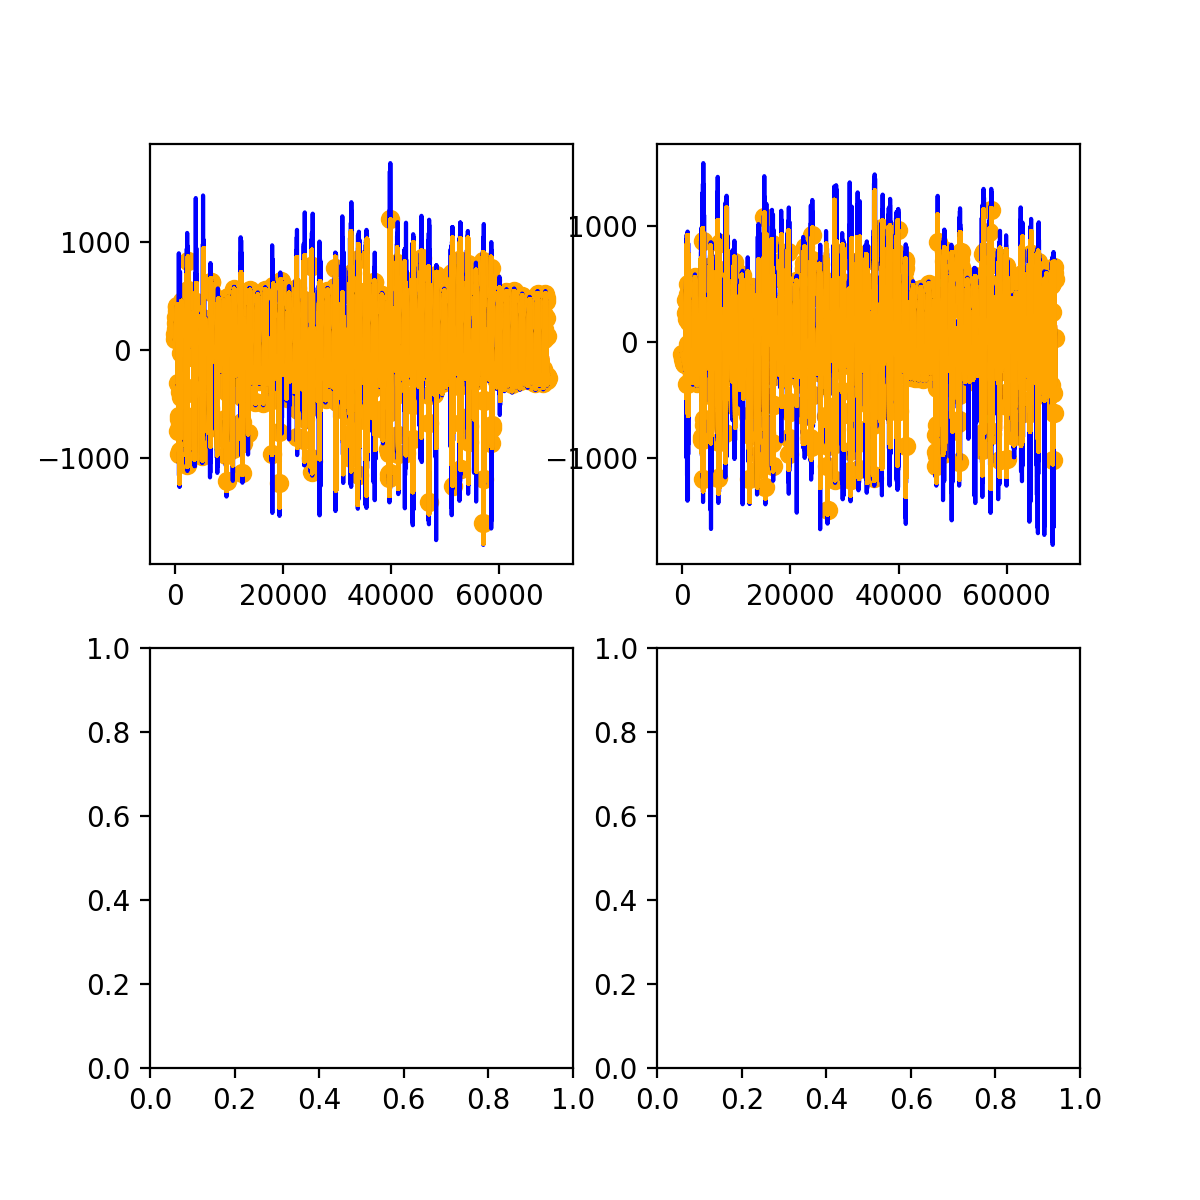

In [304]:
%matplotlib notebook
sixty_min_tester.visualise_result(repr(mva), [1, 2], figsize=(6, 6))

In [37]:
hurst_estimates.head()

,Agr Var.,Higuchi,Abs val.,avg,std
window_1_0,0.899837,0.897147,0.899166,0.898717,0.001143
window_1_1,0.857475,0.878807,0.870051,0.868778,0.008755
window_1_2,0.846924,0.866159,0.860166,0.857749,0.008036
window_1_3,0.875449,0.879919,0.881300,0.878890,0.002497
window_1_4,0.823455,0.839136,0.843857,0.835483,0.008721


In [34]:
one_min_mean_res = pd.read_csv('results/one_minute_mean_results.csv', index_col='Unnamed: 0')

In [38]:
one_min_mean_res.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE,RW_ASE
window_1_0,294.704781,383.837483,100.394378,198.038787,1.239164,924.78041,1.000144,2.572726
window_1_1,298.552672,396.917204,102.295564,198.005436,1.482369,343.55032,0.999772,2.753654
window_1_2,325.316808,427.997371,100.834016,197.182706,1.050725,-226.58157,1.000059,2.069500
window_1_3,384.561389,474.148053,100.827070,196.979927,0.984559,176.06951,0.999000,2.129180
window_1_4,288.606092,414.860941,106.939935,195.603089,0.963773,405.67981,0.999920,1.886140


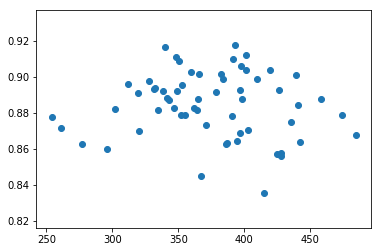

In [44]:
plt.scatter(one_min_mean_res['RMSE'], hurst_estimates['avg'])